In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, os.path

from keras.applications import ResNet50


import matplotlib.pyplot as plt

#image preprocessing libraries
import skimage
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
import math
import random
import pdb
from PIL import Image, ImageEnhance, ImageOps



In [2]:
#class for imagenet augmentation policies
class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),
            
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


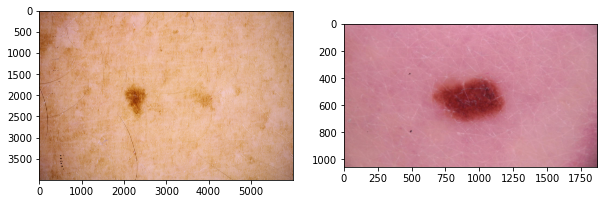

(256, 256)

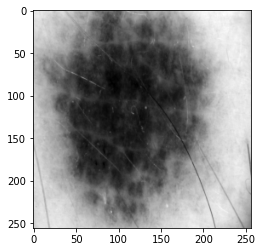

In [3]:
#path leading to training images
training_path = '../input/siim-isic-melanoma-classification/jpeg/train/' 
#generate a list of image names
training_image_names = [name for name in os.listdir(training_path)]

#testing the image loading and preporcessing
test_image = io.imread(training_path+training_image_names[2])
test_image = resize(test_image, (256, 256))
test_image = rgb2gray(test_image)

#images for augmenting
img = Image.open('../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0015719.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.imshow(img)
img2 = Image.open('../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0052212.jpg')
ax2.imshow(img2)
plt.show()


plt.imshow(test_image, cmap=plt.cm.gray)
test_image.shape


In [4]:
#create func for different image net policy in 16 images
def show_sixteen(images, titles=0):
    f, axarr = plt.subplots(4, 4, figsize=(15, 15), gridspec_kw={"wspace": 0, "hspace": 0})
    for idx, ax in enumerate(f.axes):
        ax.imshow(images[idx])
        ax.axis("off")
        if titles: ax.set_title(titles[idx])
    plt.show()

In [5]:
#show the image net policy
policy = ImageNetPolicy()

imgs = []
for _ in range(8): imgs.append(policy(img))
for _ in range(8) : imgs.append(policy(img2))
show_sixteen(imgs)

NameError: name 'SubPolicy' is not defined

In [6]:
#load training csv
training_labels = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv', sep=',')

#the train.csv holds more information than we need, thus we extract only the needed columns
training_labels = training_labels[['image_name', 'target']]

# the targets are: 0 = benign, 1 = malignant
#training labels that have a target of 0
training_labels_0 = pd.DataFrame(training_labels.loc[training_labels['target'] == 0])
#training labels that have a target of 1 
training_labels_1 = pd.DataFrame(training_labels.loc[training_labels['target'] == 1])
 
#in advance turn both pandas dataframes to numpy arrays, as we need to reshape their values later (a numpy function)
#and because the resnet model only accepts numpy arrays as inputs
training_labels_0 = np.asarray(training_labels_0)
training_labels_1 = np.asarray(training_labels_1)

#the structures of both numpy arrays are as follows:
#training_labels_# [index of the image][0 = name of the image, 1 = the target]

print("labels with a target of 0:",len(training_labels_0))
print("labels with a target of 1:",len(training_labels_1))

labels with a target of 0: 32542
labels with a target of 1: 584


In [7]:
#random data size
data_size = 2000

#prepare numpy arrays, where the loaded images and labels will be stored
training_images = np.zeros((data_size, 256, 256, 1))
training_labels = np.zeros((data_size))

#first store the images, with a target of 1
for i in range(0, len(training_labels_1)):
    #load an image
    image = io.imread(training_path+training_labels_1[i][0]+'.jpg')
    #resizing...
    image = resize(image, (256,256))
    #making the image grayscale...
    image = rgb2gray(image)
    #normalising the values...
    image /= 255
    #reshaping, because the model expects an input shape of (x,y,z)
    image = np.reshape(image, (256,256,1))
    
    #storing the image
    training_images[i] = image
    #storing the target label
    training_labels[i] = training_labels_1[i][1]
    if(i%200==0):
        #simple way of informing about the progress
        print(i, training_labels_1[i][0], "uploaded")
        
#same exact steps are applied to images, with a target of 0
for i in range(len(training_labels_1), data_size):
    image = io.imread(training_path+training_labels_0[i][0]+'.jpg')
    image = resize(image, (256,256))
    image = rgb2gray(image)
    image /= 255
    image = np.reshape(image, (256,256,1))
    
    training_images[i] = image
    training_labels[i] = training_labels_0[i][1]
    if(i%200==0):
        print(i ,training_labels_0[i][0], "uploaded")
    

0 ISIC_0149568 uploaded


200 ISIC_3435596 uploaded


400 ISIC_7070020 uploaded


In [ ]:
print(training_images.shape)
print(training_labels.shape)
from sklearn.model_selection import train_test_split
#split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(training_images, training_labels, train_size=0.8, random_state=42)

print(x_train.shape)
print(x_test.shape)

In [ ]:
training_labels[np.where(training_labels==0)].shape

In [ ]:
#The resnet model. For some reason the amount of classes in our database is 1
#No weights, because imagenet is not useful for our purpose and i'm not aware of other weights we can use
#The input shape follows the shape of the images
#Sigmoid, because our classes range from 0 and 1 and it's recommended for binary categorization
model = ResNet50(classes=1, weights=None, input_shape=(256,256,1), classifier_activation='sigmoid')

#Binary crossentropy because our classes range from 0 and 1
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#batch_size of 8 for no particular reason. Batch size of 16 caused an error, internet said it's because batch size is too big
#10 epochs, because the model is very deep and takes a very long time to train
model.fit(x_train,y_train, batch_size=8, epochs=10, validation_data=(x_test,y_test))

In [ ]:
#Use this to load all of the images
data_size = 100
training_images = np.zeros((data_size,256,256,1))
for index, imageName in enumerate(training_image_names[0:data_size]):
    image = io.imread(trainingPath+imageName)
    image = resize(image, (256, 256))
    image = rgb2gray(image)
    image /= 255
    image = np.reshape(image, (256,256,1))
    training_images[index] = image
    if(index % (data_size//4) == 0):
        print(index, imageName, "inserted")

        
training_labels = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv', sep=',')
# 0 = benign, 1 = malignant
training_labels = np.asarray(training_labels['target'])
